In [72]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from random import sample
from PIL import Image
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader, Dataset

In [73]:
IMAGE_PATH = r"D:\Desktop\IIIT D Course Material\6th sem\CV\CV - Assignments\Ass1 - Visual Recognition with Deep Learning\datasets\IDD20K_II\image_archive"
MASK_PATH = r"D:\Desktop\IIIT D Course Material\6th sem\CV\CV - Assignments\Ass1 - Visual Recognition with Deep Learning\datasets\IDD20K_II\mask_archive"

Objects:dict[int:str] = {
    0: "road",
    2: "sidewalk",
    4: "person",
    5: "rider",
    6: "motorcycle",
    7: "bicycle",
    9: "car",
    10: "truck",
    11: "bus",
    12: "train",
    14: "wall",
    15: "fence",
    18: "traffic sign",
    19: "traffic light",
    20: "pole",
    22: "building",
    24: "vegetation",
    25: "sky",
}

Cityscape_to_IDD:dict[int:int] = {
    0: 0, # road
    1: 2, # sidewalk
    2: 22, # building
    3: 14, # wall
    4: 15, # fence
    5: 20, # pole
    6: 19, # traffic light
    7: 18, # traffic sign
    8: 24, # vegetation
    9: 24, # terrain (DOES NOT EXIST IN IDD)
    10: 25, # sky
    11: 4, # person
    12: 5, # rider
    13: 9, # car
    14: 10, # truck
    15: 11, # bus
    16: 12, # train
    17: 6, # motorcycle
    18: 7,# bicycle
}

Colour_Encoding_Class = {
    0: [128, 64, 128], 
    2: [244, 35, 232], 
    4: [220, 20, 60], 
    5: [255, 0, 0], 
    6: [0, 0, 230], 
    7: [119, 11, 32], 
    9: [0, 0, 142],
    10: [0, 0, 70],
    11: [0, 60, 100], 
    12: [0, 80,100],
    14: [102, 102, 156], 
    15: [190, 153, 153],
    18: [220, 220, 0], 
    19: [250, 170, 30], 
    20: [153, 153, 153], 
    22: [70, 70, 70], 
    24: [107, 142, 35], 
    25: [70, 130, 180], 
}


In [74]:
# Load the names of all images in a directory which have both a mask and a image
def load_images(directory):
    images = set()
    for filename in os.listdir(directory):
        if filename.endswith('.jpg'):
            images.add(int((filename.split("_")[1]).split(".")[0]))
    return images

imgs = load_images(IMAGE_PATH)
masks = load_images(MASK_PATH)

common_images = list(imgs.intersection(masks))
common_images = sample(common_images, int(0.3*len(common_images)))

In [75]:
class IDD_Dataset(Dataset):

    def __init__(self, img_dir, image_list, name_pattern, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.image_list = image_list
        self.name_pattern = name_pattern
        
    def __len__(self):
        return len(self.image_list)
    
    def __getitem__(self, idx):
        img_num = self.image_list[idx]
        img_name = os.path.join(self.img_dir, self.name_pattern(img_num))
        image = Image.open(img_name).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image

In [76]:
def ColorClassinMap(image):
    image = np.array(image)
    new_image = np.zeros((image.shape[0], image.shape[1], 3))
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if image[i][j][0] in Objects:
                new_image[i][j] = Colour_Encoding_Class[image[i][j][0]]
    return new_image

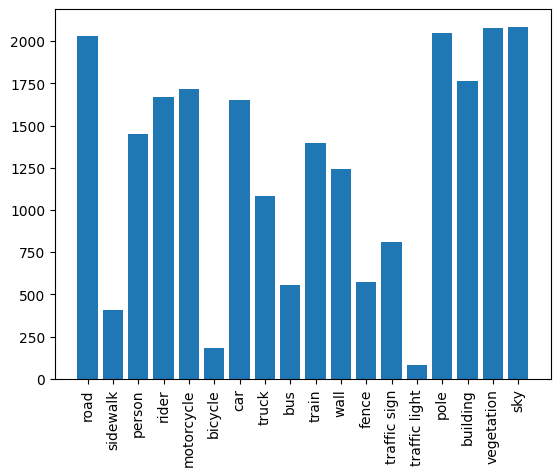

road


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


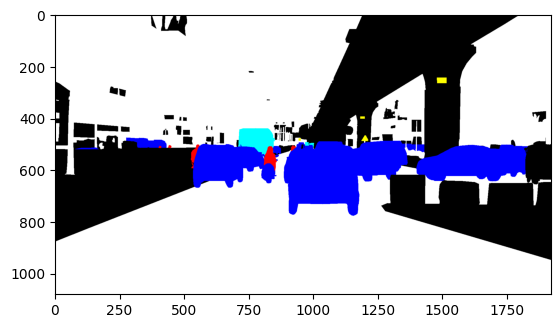

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


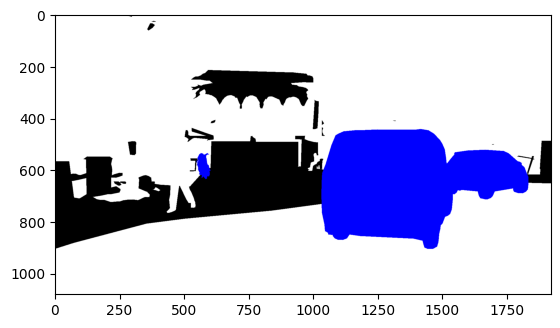

sidewalk


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


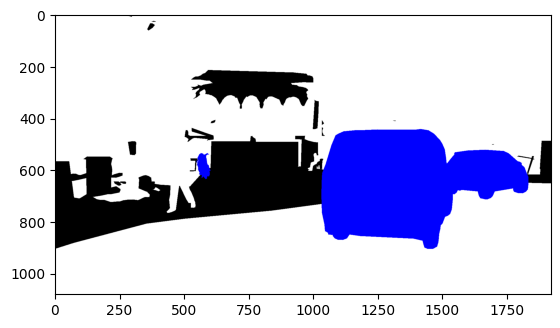

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


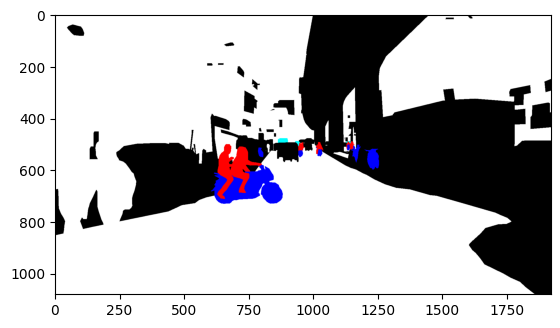

person


KeyboardInterrupt: 

In [77]:
transform = torchvision.transforms.Compose([torchvision.transforms.Resize((512, 512)), torchvision.transforms.ToTensor()])
transform1 = torchvision.transforms.Resize((512, 512))
mask_dataset = IDD_Dataset(MASK_PATH, common_images, lambda x: f"mask_{x}.jpg", transform=None)

# Loading all the masks to a dict to find the number of instances of each class
mask_cnt:dict[str:int] = {}
mask_example:dict[str:list[int]] = {}
for val in Objects.values():
    mask_example[val] = []
    mask_cnt[val] = 0
for i in range(len(mask_dataset)):
    uniq_vals = np.unique(mask_dataset[i])
    for val in uniq_vals:
        if val.item() not in Objects:
            continue
        mask_cnt[Objects[val.item()]] += 1
        if len(mask_example[Objects[val.item()]]) < 2:
            mask_example[Objects[val.item()]].append(i)

# Plotting the number of instances of each class
plt.bar(mask_cnt.keys(), mask_cnt.values())
plt.xticks(rotation=90)
plt.show()

# Plotting the first and second instance of each class and colouring the mask
for key in mask_example:
    print(key)
    plt.imshow(ColorClassinMap(mask_dataset[mask_example[key][0]]))
    plt.show()
    plt.imshow(ColorClassinMap(mask_dataset[mask_example[key][1]]))
    plt.show()


In [84]:
def TransformMaskandFilter(mask, transform:None):
    trans_mask = transform(mask)
    mask = np.array(mask)
    trans_mask = np.array(trans_mask)
    mask = mask[:,:,0]
    trans_mask = trans_mask[:,:,0]
    og_classes = np.unique(mask)
    for i in range(512):
        for j in range(512):
            if trans_mask[i][j] not in og_classes:
                trans_mask[i][j] = 0
    return trans_mask

In [93]:
sys.path.append(r"D:\Desktop\IIIT D Course Material\6th sem\CV\CV - Assignments\Ass1 - Visual Recognition with Deep Learning\DeepLabV3Plus-Pytorch-master")
import network

img_dataset = IDD_Dataset(IMAGE_PATH, common_images, lambda x: f"image_{x}.jpg", transform=transform)
dataloader = DataLoader(img_dataset, batch_size=1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MODEL_NAME:str = "deeplabv3plus_resnet101"
NUM_CLASSES:int = 19
PATH_TO_PTH:str = r"D:\Desktop\IIIT D Course Material\6th sem\CV\CV - Assignments\Ass1 - Visual Recognition with Deep Learning\pretrained-models\best_deeplabv3plus_resnet101_cityscapes_os16.pth.tar"

# Initialising dictionary to store accuracy benchmarks
count_occurances:dict[str:int] = {}
pixel_wise_accuracy:dict[str:[int, int]] = {}
dice_coefficient:dict[str:float] = {}
iou:dict[str:float] = {}
true_positive:dict[str:int] = {}
false_positive:dict[str:int] = {}
false_negative:dict[str:int] = {}
example_images:dict[str:list[list[int, np.ndarray, np.ndarray]]] = {}
for val in Objects:
    count_occurances[val] = 0
    pixel_wise_accuracy[val] = [0, 0]
    dice_coefficient[val] = 0
    iou[val] = 0
    true_positive[val] = 0
    false_positive[val] = 0
    false_negative[val] = 0
    example_images[val] = []
confusion_matrix = [[0 for _ in range(max(Objects.keys()) + 2)] for _ in range(max(Objects.keys()) + 2)] # +1 for the background class

model = network.modeling.__dict__[MODEL_NAME](num_classes=NUM_CLASSES, output_stride=16)
model.load_state_dict(torch.load(PATH_TO_PTH, map_location=torch.device('cpu'))['model_state'])
model = model.to(device)
model.eval()

# Using the model to predict the masks
for i, data in enumerate(dataloader):
    # output the image and the mask
    image = data.to(device)
    output = model(image)
    pred = output.max(1)[1].cpu().numpy()
    pred = pred.astype(np.uint8)

    mask = TransformMaskandFilter(mask_dataset[i], transform1)
    pred = pred[0]
    for j in range(512):
        for k in range(512):
            if pred[j][k] in Cityscape_to_IDD:
                pred[j][k] = Cityscape_to_IDD[pred[j][k]]
            else :
                pred[j][k] = 0

    # Printing the mask and the prediction
    # plt.imshow(pred)
    # plt.show()
    # plt.imshow(mask)
    # plt.show()

    # Find all the classes in the mask and the prediction
    mask_classes = np.unique(mask)
    pred_classes = np.unique(pred)
    all_classes = np.unique(np.concatenate((mask_classes, pred_classes)))

    # Checking for true positives, false positives and false negatives
    for val in all_classes:
        if val not in Objects:
            continue
        if val in mask_classes and val in pred_classes:
            true_positive[val] += 1
        elif val in mask_classes and val not in pred_classes:
            false_negative[val] += 1
        elif val not in mask_classes and val in pred_classes:
            false_positive[val] += 1

    # Calculating the pixel wise accuracy, dice coefficient and iou
    class_wise_vals = {}
    for val in all_classes:
        if val not in Objects:
            continue
        class_wise_vals[val] = [0, 0, 0] # [Both same class, either same class, mask class]
        count_occurances[val] += 1

    for i in range(512):
        for j in range(512):
            if pred[i][j] == mask[i][j]:
                if pred[i][j] in Objects:
                    class_wise_vals[pred[i][j]][0] += 1
                    class_wise_vals[pred[i][j]][1] += 1
            else:
                if pred[i][j] in Objects:
                    class_wise_vals[pred[i][j]][1] += 1
                if mask[i][j] in Objects:
                    class_wise_vals[mask[i][j]][1] += 1   
            if mask[i][j] in Objects:
                class_wise_vals[mask[i][j]][2] += 1   
            mask_val = mask[i][j] if mask[i][j] in Objects else max(Objects.keys()) + 1
            pred_val = pred[i][j] if pred[i][j] in Objects else max(Objects.keys()) + 1
            confusion_matrix[mask_val][pred_val] += 1

    for val in class_wise_vals:
        pixel_wise_accuracy[val][0] += class_wise_vals[val][0]
        pixel_wise_accuracy[val][1] += class_wise_vals[val][2]
        class_dice_coefficient = (2*class_wise_vals[val][0])/(class_wise_vals[val][0]+class_wise_vals[val][1])
        class_iou = class_wise_vals[val][0]/class_wise_vals[val][1]
        dice_coefficient[val] = (dice_coefficient[val]*(count_occurances[val] - 1) + class_dice_coefficient)/count_occurances[val]
        iou[val] += (iou[val]*(count_occurances[val] - 1) + class_iou)/count_occurances[val]
        # Saving the first 3 examples of the class with iou < 0.5
        if (class_iou < 0.5) and (len(example_images[val]) < 3):
            example_images[val].append([i, mask, pred])


    if i >= 10:
        break

In [92]:
# Pickle the results in different files for future use
import pickle
with open("count_occurances.pickle", "wb") as file:
    pickle.dump(count_occurances, file)
with open("pixel_wise_accuracy.pickle", "wb") as file:
    pickle.dump(pixel_wise_accuracy, file)
with open("dice_coefficient.pickle", "wb") as file:
    pickle.dump(dice_coefficient, file)
with open("iou.pickle", "wb") as file:
    pickle.dump(iou, file)
with open("true_positive.pickle", "wb") as file:
    pickle.dump(true_positive, file)
with open("false_positive.pickle", "wb") as file:
    pickle.dump(false_positive, file)
with open("false_negative.pickle", "wb") as file:
    pickle.dump(false_negative, file)
with open("example_images.pickle", "wb") as file:
    pickle.dump(example_images, file)
with open("confusion_matrix.pickle", "wb") as file:
    pickle.dump(confusion_matrix, file)

(512, 512)


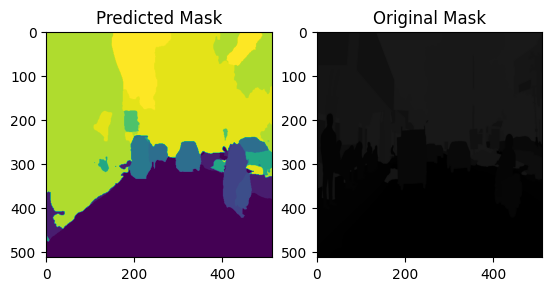

In [48]:
pred = output.max(1)[1].detach().cpu().numpy()
pred_img = pred.astype(np.uint8)
pred_img = pred_img[0]
# Converting pred from Cityscape to IDD
for i in range(pred_img.shape[0]):
    for j in range(pred_img.shape[1]):
        if pred_img[i][j] in Cityscape_to_IDD:
            pred_img[i][j] = Cityscape_to_IDD[pred_img[i][j]]
        else:
            pred[i][j] = 0
print(pred_img.shape)
plt.subplot(1, 2, 1)  # 1 row, 2 columns, index 1
plt.imshow(pred_img)
plt.title('Predicted Mask')

# Get the first mask and plot it to compare
mask = mask_dataset[0]
trans_mask = transform1(mask)
plt.subplot(1, 2, 2)  # 1 row, 2 columns, index 2
plt.imshow(trans_mask, cmap = 'viridis')
plt.title('Original Mask')

# Show both mask and predicted mask
plt.show()